<a href="https://colab.research.google.com/github/halim-jun/Ai_study/blob/master/%5BE8%5DKaggle_House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[결과]

- RMSE : 11만 달성
- Hyperparameter tuning(Grid search), ensemble method 이용
>- GradientBoosting
>- XGBoost
>- LightGBM
>- Randomforest

- Feature engineering 이용

#[느낀점]

마지막 1% 올리기가 너무 어렵다..

#1. 파일 업로드 및 필요한 라이브러리 임포트

In [3]:
from google.colab import files

In [ ]:
upload=files.upload()

In [600]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


In [601]:
train=pd.read_csv("train.csv")

In [602]:
train.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,1,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
2,2,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503
3,3,20140627T000000,257500.00,3,2.25,1715,6819,2.00,0,0,3,7,1715,0,1995,0,98003,47.31,-122.33,2238,6819
4,4,20150115T000000,291850.00,3,1.50,1060,9711,1.00,0,0,3,7,1060,0,1963,0,98198,47.41,-122.31,1650,9711
5,5,20150403T000000,662500.00,3,2.50,3560,9796,1.00,0,0,3,8,1860,1700,1965,0,98007,47.60,-122.14,2210,8925
6,6,20140527T000000,468000.00,2,1.00,1160,6000,1.00,0,0,4,7,860,300,1942,0,98115,47.69,-122.29,1330,6000
7,7,20140528T000000,310000.00,3,1.00,1430,19901,1.50,0,0,4,7,1430,0,1927,0,98028,47.76,-122.23,1780,12697
8,8,20141007T000000,400000.00,3,1.75,1370,9680,1.00,0,0,4,7,1370,0,1977,0,98074,47.61,-122.05,1370,10208
9,9,20150312T000000,530000.00,5,2.00,1810,4850,1.50,0,0,3,7,1810,0,1900,0,98107,47.67,-122.39,1360,4850


In [603]:
train.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.00,15035.00,15035.00,15035.00,15035.00,15035.00,15035.00,15035.00,15035.00,15035.00,15035.00,15035.00,15035.00,15035.00,15035.00,15035.00,15035.00,15035.00,15035.00,15035.00
mean,7517.00,540682.65,3.37,2.12,2083.79,15296.97,1.50,0.01,0.23,3.41,7.66,1794.16,289.63,1971.10,83.80,98078.03,47.56,-122.21,1992.75,12823.88
std,4340.37,371524.66,0.90,0.77,922.13,42612.82,0.54,0.08,0.76,0.65,1.18,831.74,440.66,29.41,400.40,53.30,0.14,0.14,691.46,27736.26
min,0.00,78000.00,0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,3758.50,322000.00,3.00,1.75,1430.00,5027.50,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,7517.00,450000.00,3.00,2.25,1910.00,7620.00,1.50,0.00,0.00,3.00,7.00,1570.00,0.00,1975.00,0.00,98065.00,47.57,-122.23,1850.00,7610.00
75%,11275.50,645000.00,4.00,2.50,2560.00,10695.50,2.00,0.00,0.00,4.00,8.00,2230.00,550.00,1997.00,0.00,98117.00,47.68,-122.13,2360.00,10076.00
max,15034.00,7700000.00,10.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4130.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00


1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
집에 대한 다양한 정보가 들어있는 것으로 보입니다. 이들의 특징을 활용해서 집의 가격을 맞추어

#2.  데이터 전처리

##1) 필요한 데이터만 자르기
- date slicing (날짜만 추출하기)


In [604]:
train['date']=train['date'].apply(lambda x:x[0:8])
train.head(10)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,1,20150225,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
2,2,20150218,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503
3,3,20140627,257500.00,3,2.25,1715,6819,2.00,0,0,3,7,1715,0,1995,0,98003,47.31,-122.33,2238,6819
4,4,20150115,291850.00,3,1.50,1060,9711,1.00,0,0,3,7,1060,0,1963,0,98198,47.41,-122.31,1650,9711
5,5,20150403,662500.00,3,2.50,3560,9796,1.00,0,0,3,8,1860,1700,1965,0,98007,47.60,-122.14,2210,8925
6,6,20140527,468000.00,2,1.00,1160,6000,1.00,0,0,4,7,860,300,1942,0,98115,47.69,-122.29,1330,6000
7,7,20140528,310000.00,3,1.00,1430,19901,1.50,0,0,4,7,1430,0,1927,0,98028,47.76,-122.23,1780,12697
8,8,20141007,400000.00,3,1.75,1370,9680,1.00,0,0,4,7,1370,0,1977,0,98074,47.61,-122.05,1370,10208
9,9,20150312,530000.00,5,2.00,1810,4850,1.50,0,0,3,7,1810,0,1900,0,98107,47.67,-122.39,1360,4850


In [605]:
test=pd.read_csv("test.csv")
test.head(10)
test['date']=test['date'].apply(lambda x:x[0:8])

In [606]:
test['date']=test['date'].apply(lambda x:x[0:8])

## 2) Checking the distribution

**Highly skewed 된 데이터의 분포만 바꿔줌 (skewness 절대값 1 이상인 칼럼들)**

- Feature data 에 skewed data 가 있는지 확인
*확인하는 이유 : "Why do we care if the data is skewed? If the response variable is skewed like in Kaggle’s House Prices Competition, **the model will be trained on a much larger number of moderately priced homes, and will be less likely to successfully predict the price for the most expensive houses**. The concept is the same as training a model on imbalanced categorical classes."



---

https://www.geeksforgeeks.org/scipy-stats-skew-python/#:~:text=skew(array%2C%20axis%3D0,right%20tail%20of%20the%20distribution.

####**Skewness**   

:As a general rule of thumb:

If skewness is less than -1 or greater than 1, the distribution is highly skewed.
If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

- skewness 의 절대값이 1 이상일 경우 심각하게 skew 되었다고 일반적으로 여겨짐
- 하단의 칼럼들 : skewneww 절대값이 1 이상인 칼럼

### (1) train.Skew() 확인

In [612]:
skew=pd.DataFrame(train.skew(), columns=[ 'skew'])
highly_skew=skew[(skew['skew']>1)|(skew['skew']<-1)]
highly_skew

,skew
price,4.29
sqft_living,1.49
sqft_lot,13.35
waterfront,11.73
view,3.38
condition,1.04
sqft_above,1.43
sqft_basement,1.56
yr_renovated,4.57
sqft_living15,1.13


In [613]:
skew_columns=['price',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'sqft_lot15']

IndexError: ignored

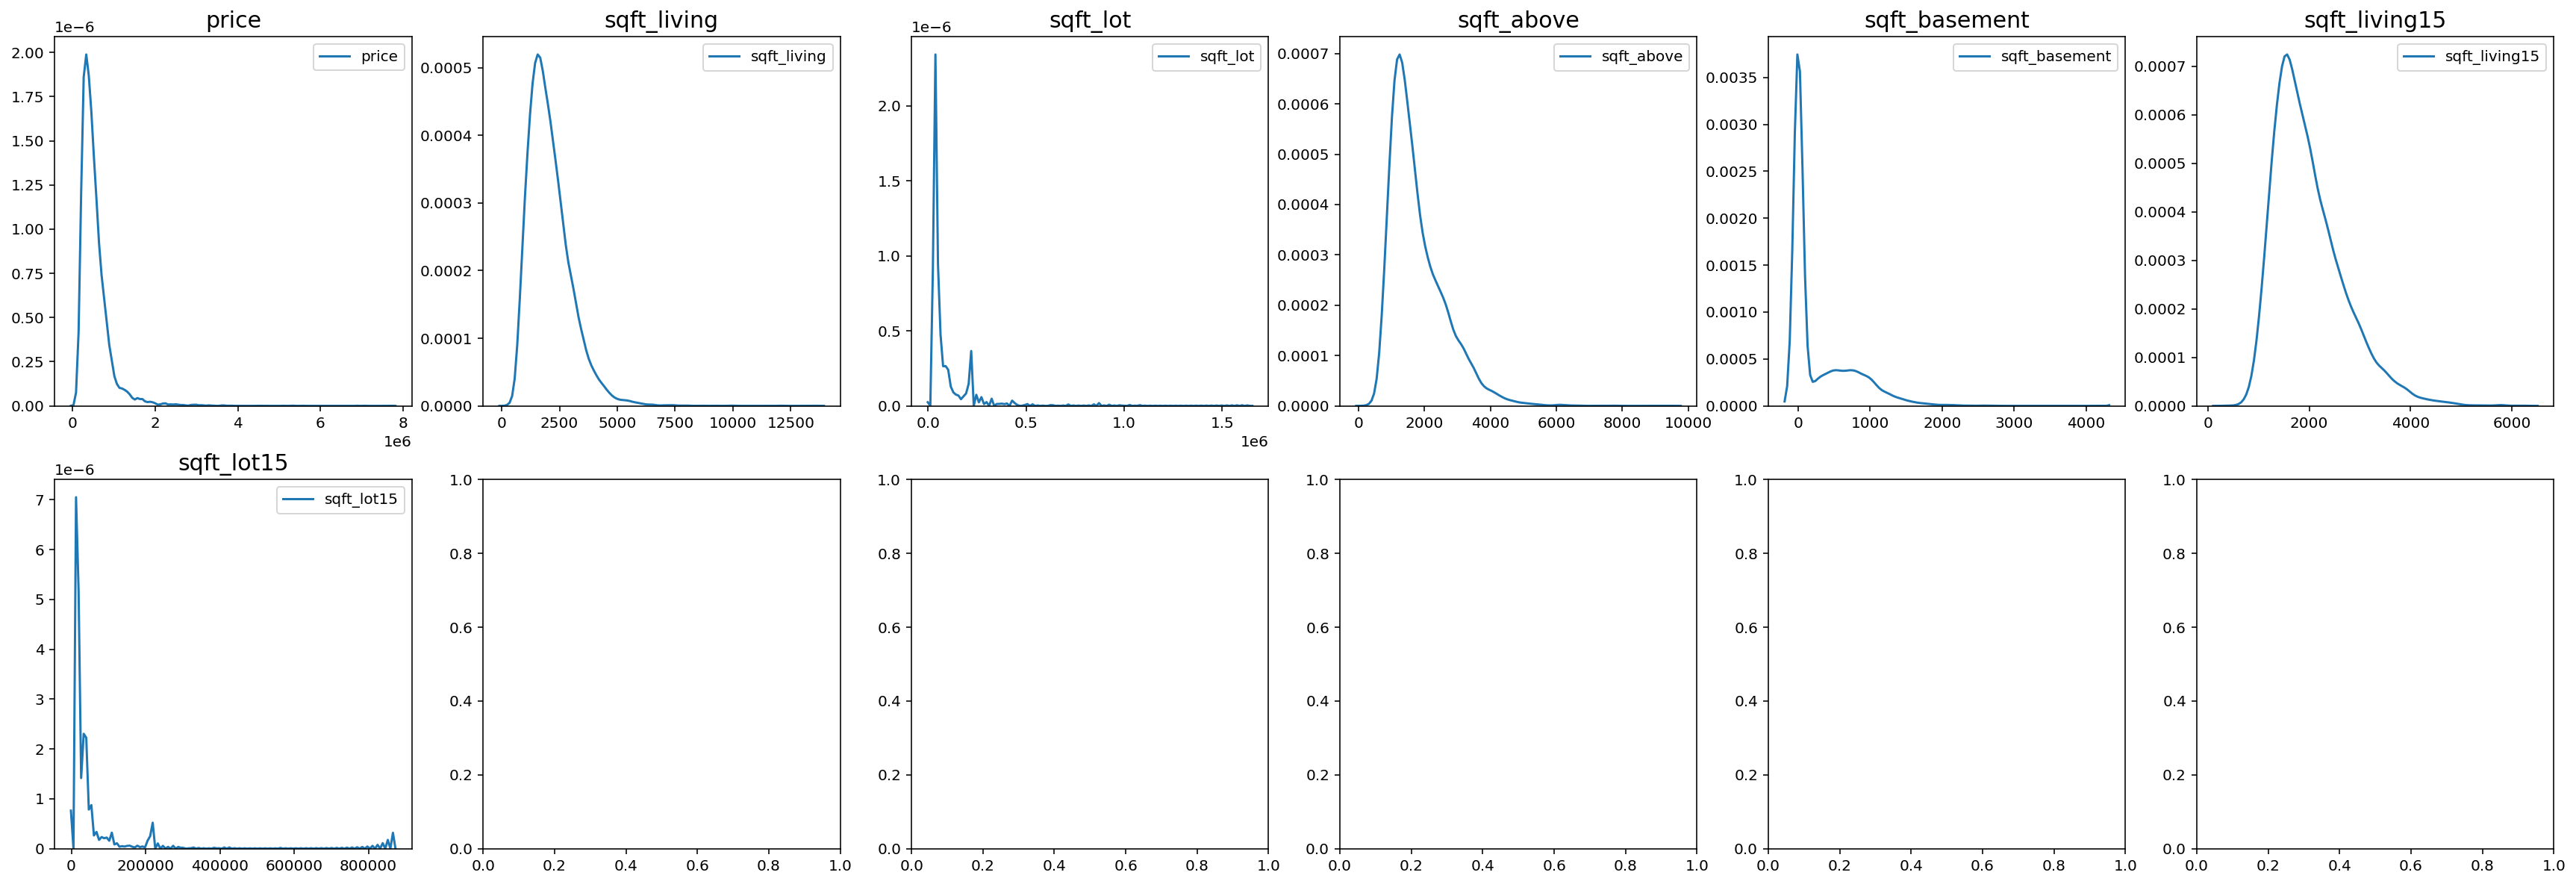

In [614]:
import seaborn as sns
fig, ax = plt.subplots(2, 6, figsize=(30, 10))    
count = 0
for row in range(2):
    for col in range(6):
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1
        if count == 11 :
            break

### (2).Skewed columns log 변환

- skewness 가 절대값 1 이상인 칼럼을 skewcolumns 에 저장한뒤 해당 리스트에 속하는 칼럼을 log 변환 하였다. 
- 단, categorical data는 skewed 되어있어도 묵인하였다 (어차피 discrete 한 데이터이기 때문에 분포가 의미없다고 생각하였다)

In [615]:
for c in skew_columns:
  train[c]=np.log1p(train[c])

### (3) log 변환 후 분포 시각화 및 skewness 확인

- 그래프로 그려보았을때, 로그변환한 뒤 더 가우시안 분포와 유사해진것을 확인할 수 있다.

IndexError: ignored

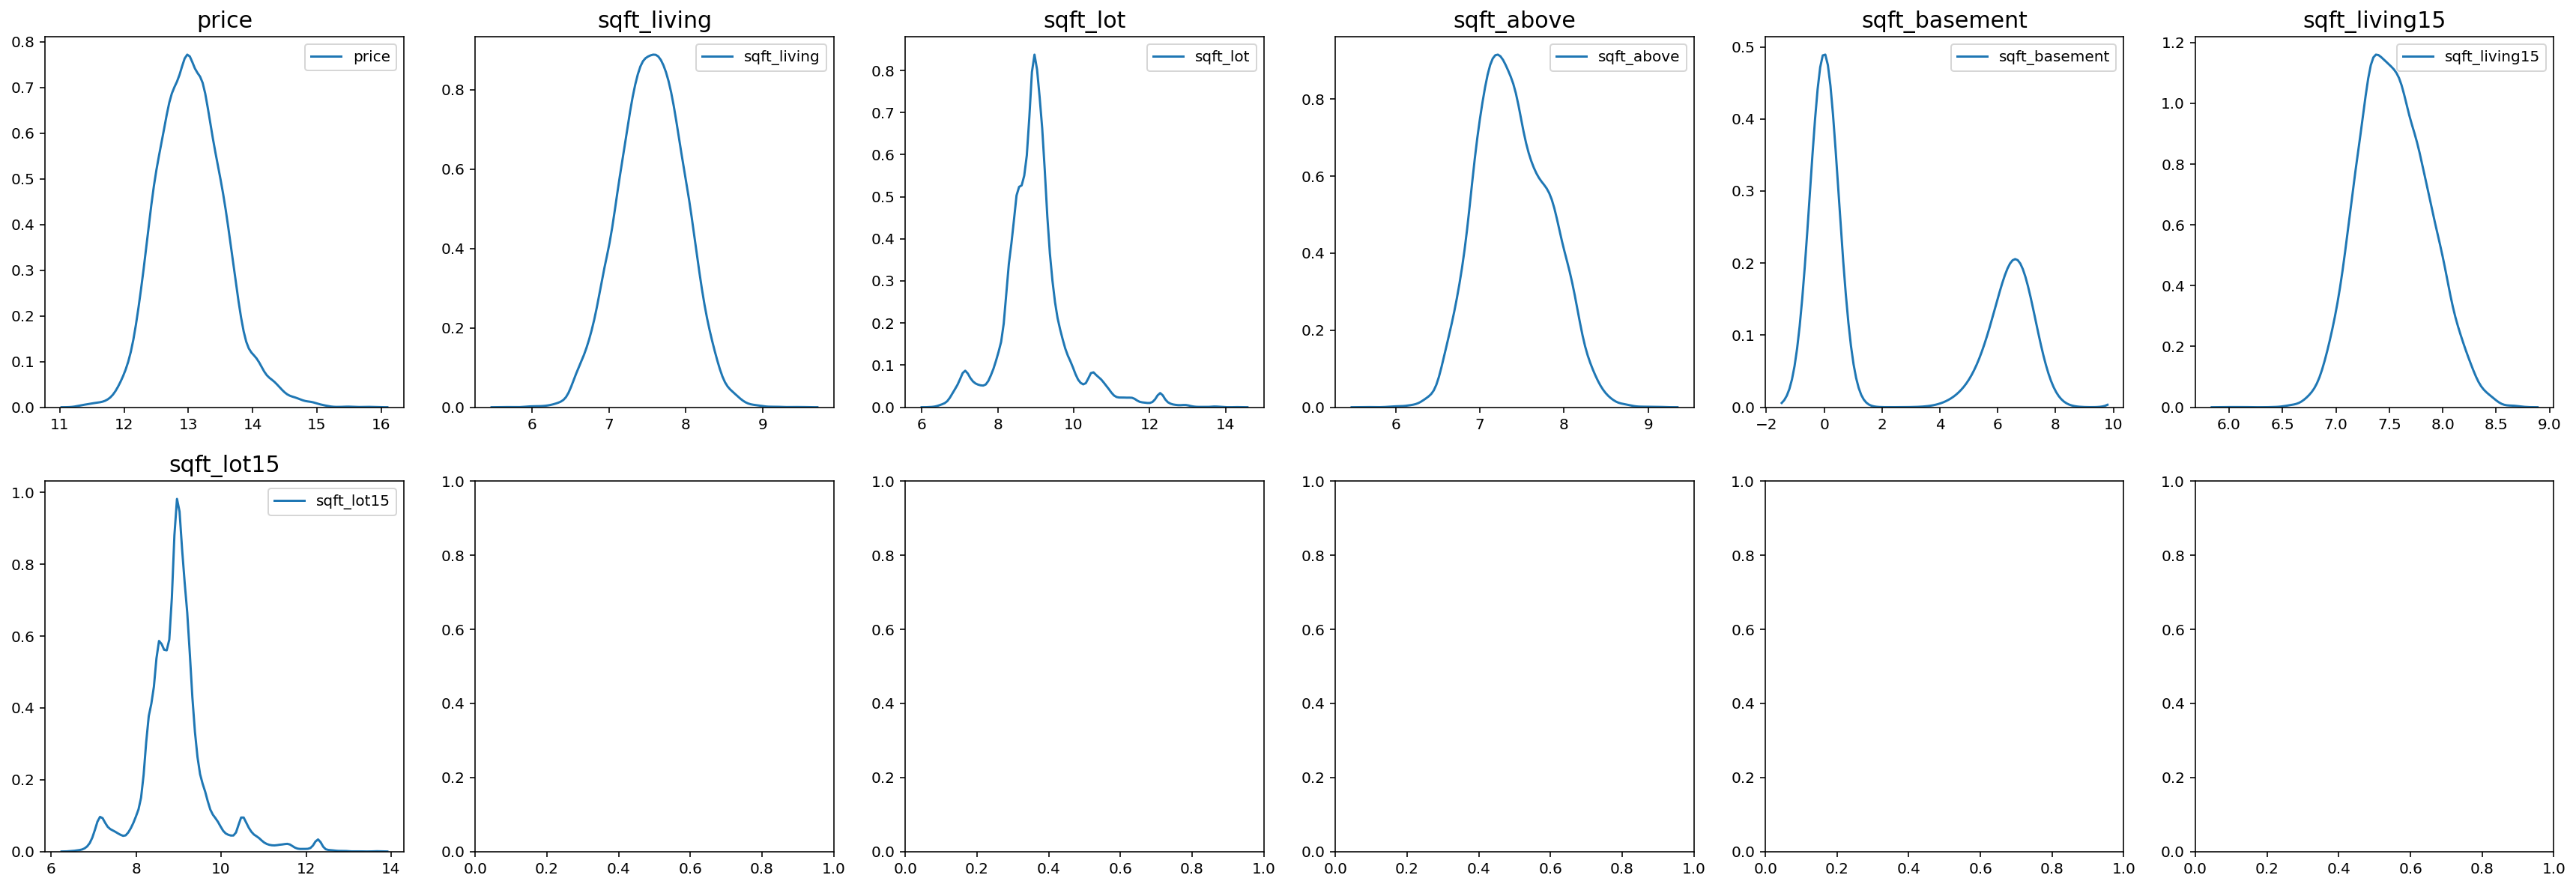

In [616]:
fig, ax=plt.subplots(2,6, figsize=(30,10))
count=0

for ro in range(2):
  for col in range(6):
    sns.kdeplot(train[skew_columns[count]], ax=ax[ro][col])
    ax[ro][col].set_title(skew_columns[count], fontsize=15)

    count+=1
    if count==11:
      break

In [617]:
new_skew=pd.DataFrame(train.skew(), columns=['log_trans_skewed'])
pd.merge(highly_skew,new_skew.loc[skew_columns], left_index=True, right_index=True)

,skew,log_trans_skewed
price,4.29,0.43
sqft_living,1.49,-0.04
sqft_lot,13.35,0.99
sqft_above,1.43,0.24
sqft_basement,1.56,0.49
sqft_living15,1.13,0.21
sqft_lot15,10.03,0.99


- 테스트 데이터에서도 마찬가지

In [618]:
skew_columns

['price',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'sqft_lot15']

In [619]:
for c in ['sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'sqft_lot15']:
  test[c]=np.log1p(test[c])

## 3) Null data 확인

- Null data 를 확인한 결과 0건이 발견되어 기타의 전처리는 하지 않았다.

In [620]:
train.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [621]:
train.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## 4) Data type 확인

- Date 칼럼이 Object type인것으로 확인됨
- 이에 따라 integer type 으로 변환

In [622]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  float64
 6   sqft_lot       15035 non-null  float64
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  float64
 13  sqft_basement  15035 non-null  float64
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [623]:
train['date']=train['date'].astype(int)
train.info()
train['date']=train['date'].astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  int64  
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  float64
 6   sqft_lot       15035 non-null  float64
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  float64
 13  sqft_basement  15035 non-null  float64
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

#3. 데이터 EDA

##1)train_ y 에 대한 이해

In [624]:
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format


Text(0.5, 1.0, 'price')

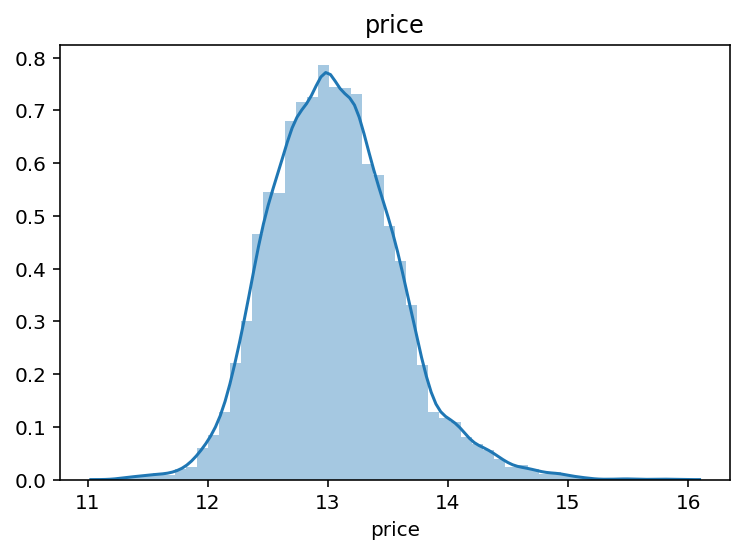

In [625]:
fig=sns.distplot(train['price'])
fig.set_title('price')

- 로그 변환을 해줬으므로 적절히 넓게 분산되어있는 모양이다.

In [626]:

round(np.expm1(13), -1)

442410.0

In [627]:
print('mean : {}'.format(round(np.expm1(train['price'].mean()),0)))
print('25% : {}'.format(round(np.expm1(train['price'].quantile(0.25)),0)))
print('75% : {}'.format(round(np.expm1(train['price'].quantile(0.75)),0)))

mean : 464223.0
25% : 322000.0
75% : 645000.0


- 각 4분위 값을 통해 로그 변환 전 실제 분포를 확인해보았다.
>- 대략 32만 ~ 64만 사이에 전체적인 값이 몰려있을 것을 유추 가능하다 

## 2) X-y 상관관계에 대한 이해

- Train 시키기 이전 어떤 칼럼이 y 와 연관되어있을지 확인해보았다. 

In [628]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,12.31,3,1.00,7.07,8.64,1.00,0,0,3,7,7.07,0.00,1955,0,98178,47.51,-122.26,7.20,8.64
1,1,20150225,12.10,2,1.00,6.65,9.21,1.00,0,0,3,6,6.65,0.00,1933,0,98028,47.74,-122.23,7.91,9.00
2,2,20150218,13.14,3,2.00,7.43,9.00,1.00,0,0,3,8,7.43,0.00,1987,0,98074,47.62,-122.05,7.50,8.92
3,3,20140627,12.46,3,2.25,7.45,8.83,2.00,0,0,3,7,7.45,0.00,1995,0,98003,47.31,-122.33,7.71,8.83
4,4,20150115,12.58,3,1.50,6.97,9.18,1.00,0,0,3,7,6.97,0.00,1963,0,98198,47.41,-122.31,7.41,9.18


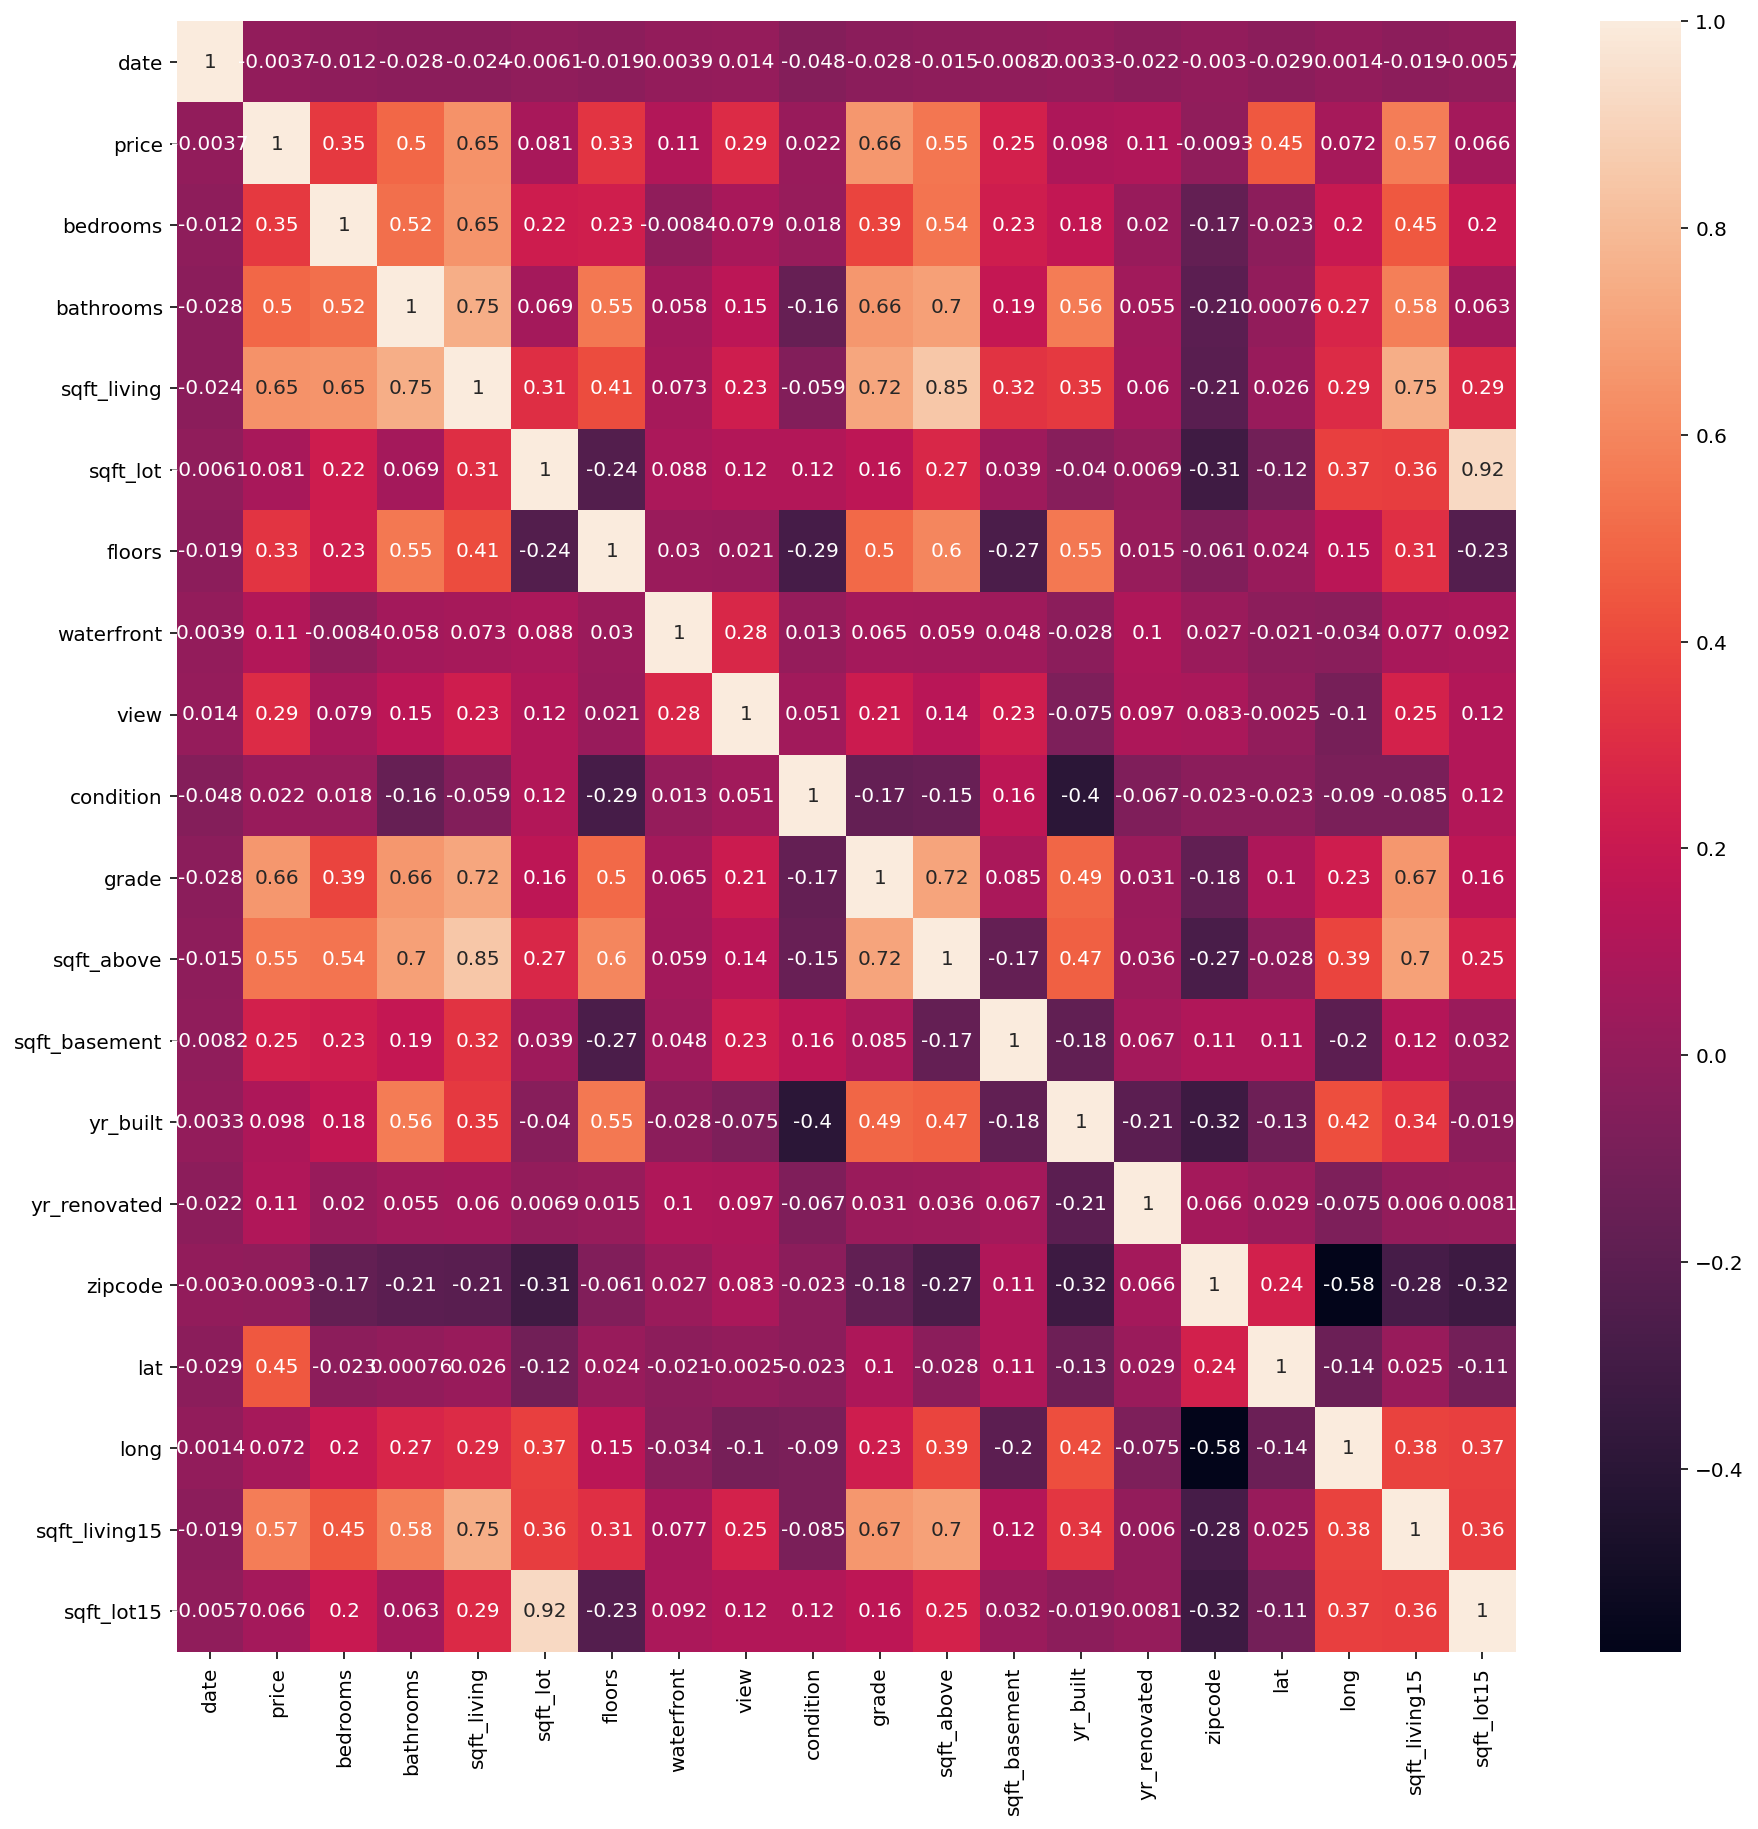

In [629]:
train_corr=train.drop('id', axis=1).corr(method='spearman')
plt.figure(figsize=(15,15))
sns.heatmap(train_corr, annot=True)

In [630]:
train_corr['price']*100

date             -0.37
price           100.00
bedrooms         35.02
bathrooms        49.90
sqft_living      64.65
sqft_lot          8.06
floors           32.87
waterfront       11.32
view             29.17
condition         2.15
grade            66.21
sqft_above       54.79
sqft_basement    24.53
yr_built          9.78
yr_renovated     11.24
zipcode          -0.93
lat              45.07
long              7.18
sqft_living15    57.38
sqft_lot15        6.58
Name: price, dtype: float64

 집의 크기가 집 값과 연관성이 크다는 유추를 할 수 있다.
- 집의 평수나 등급이 가장 유의미한 요인이다. 
- 그 외에 화장실의 수나 침실의 수도 다음순위로 유의미하다.


##3. Feature engineering

##1) Zip code

- Onehot encoding 을 하였으나, 이 경우 accuracy 가 매우 저조하여 이후 배제   
- Tree model 이라서 필요하지 않음

In [631]:
train['zipcode']

0        98178
1        98028
2        98074
3        98003
4        98198
         ...  
15030    98056
15031    98136
15032    98103
15033    98146
15034    98144
Name: zipcode, Length: 15035, dtype: int64

In [571]:
# train['zipcode']=train['zipcode'].astype('str')
# zip_unique=train['zipcode'].unique()
# zip_list=[[i] for i in train['zipcode']]

# test['zipcode']=test['zipcode'].astype('str')
# zip_unique=test['zipcode'].unique()
# zip_list_test=[[i] for i in test['zipcode']]


In [573]:
# example of a one hot encoding
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder
# define data
#data = asarray([['red'], ['green'], ['blue']])
#print(data)
# define one hot encoding
encoder = OneHotEncoder(sparse=False)
# transform data
onehot_zip = encoder.fit_transform(zip_list)
print(onehot_zip)
onehot_zip=pd.DataFrame(onehot_zip)
print(onehot_zip)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
        0    1    2    3    4    5    6   ...   63   64   65   66   67   68   69
0     0.00 0.00 0.00 0.00 0.00 0.00 0.00  ... 0.00 0.00 0.00 1.00 0.00 0.00 0.00
1     0.00 0.00 0.00 0.00 0.00 0.00 0.00  ... 0.00 0.00 0.00 0.00 0.00 0.00 0.00
2     0.00 0.00 0.00 0.00 0.00 0.00 0.00  ... 0.00 0.00 0.00 0.00 0.00 0.00 0.00
3     0.00 0.00 1.00 0.00 0.00 0.00 0.00  ... 0.00 0.00 0.00 0.00 0.00 0.00 0.00
4     0.00 0.00 0.00 0.00 0.00 0.00 0.00  ... 0.00 0.00 0.00 0.00 0.00 1.00 0.00
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
15030 0.00 0.00 0.00 0.00 0.00 0.00 0.00  ... 0.00 0.00 0.00 0.00 0.00 0.00 0.00
15031 0.00 0.00 0.00 0.00 0.00 0.00 0.00  ... 0.00 0.00 0.00 0.00 0.00 0.00 0.00
15032 0.00 0.00 0.00 0.00 0.00 0.00 0.00  ... 0.00 0.00 0.00 0.00 0.00 0.00 0.00
15033 0.00 0.00 0.00 0.00 0.00 0.0

In [574]:
# train.drop('zipcode', axis=1, inplace=True)
# train.head()
# pd.concat((train, onehot_zip), axis=1)

In [575]:
# define one hot encoding
encoder = OneHotEncoder(sparse=False)
# transform data
# onehot_zip_test = encoder.fit_transform(zip_list_test)
onehot_zip_test=pd.DataFrame(onehot_zip_test)
print(onehot_zip_test)


# test.drop('zipcode', axis=1, inplace=True)
# test.head()
# pd.concat((test, onehot_zip_test), axis=1)

       0    1    2    3    4    5    6   ...   63   64   65   66   67   68   69
0    0.00 0.00 0.00 0.00 0.00 0.00 0.00  ... 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1    0.00 0.00 0.00 0.00 0.00 0.00 0.00  ... 0.00 0.00 0.00 0.00 0.00 0.00 0.00
2    0.00 0.00 0.00 0.00 0.00 0.00 0.00  ... 0.00 0.00 0.00 0.00 0.00 0.00 0.00
3    0.00 0.00 0.00 0.00 0.00 0.00 0.00  ... 0.00 0.00 0.00 0.00 0.00 0.00 0.00
4    0.00 0.00 0.00 0.00 0.00 0.00 0.00  ... 0.00 0.00 0.00 0.00 0.00 0.00 0.00
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
6463 0.00 0.00 0.00 0.00 0.00 0.00 0.00  ... 0.00 0.00 0.00 0.00 0.00 0.00 0.00
6464 0.00 0.00 0.00 0.00 0.00 0.00 0.00  ... 0.00 0.00 0.00 0.00 0.00 0.00 0.00
6465 0.00 0.00 0.00 0.00 0.00 0.00 0.00  ... 0.00 0.00 0.00 0.00 0.00 0.00 0.00
6466 0.00 0.00 0.00 0.00 0.00 0.00 0.00  ... 0.00 0.00 0.00 0.00 0.00 0.00 0.00
6467 0.00 0.00 0.00 0.00 0.00 0.00 0.00  ... 0.00 0.00 0.00 0.00 0.00 0.00 0.00

[6468 rows x 70 columns]


## 2) Date

- 구매 연도만 사용

In [632]:
train['date']=train['date'].astype('str')
train['year']=train['date'].apply(lambda x: x[:4])
train['year']=train['year'].astype('int')
#train['date']=train['date'].astype('int')
train.drop('date', axis=1, inplace=True)

In [633]:
test['date']=test['date'].astype('str')
test['year']=test['date'].apply(lambda x: x[:4])
test['year']=test['year'].astype('int')
#test['date']=test['date'].astype('int')
test.drop('date', axis=1, inplace=True)

#3) yr_renovated

In [634]:
train['yr_renovated'].unique()

array([   0, 2002, 1999, 1991, 1978, 2005, 2008, 2003, 1994, 1984, 1954,
       2014, 2011, 1974, 1983, 2013, 1990, 1957, 1977, 1981, 1995, 2000,
       1986, 1992, 2004, 2007, 1987, 2006, 1985, 1971, 1945, 1979, 1997,
       2010, 1969, 1948, 2009, 1970, 2015, 1989, 2001, 1968, 2012, 1963,
       1993, 1962, 1972, 1980, 1998, 1955, 1996, 1950, 1956, 1982, 1988,
       1940, 1946, 1975, 1964, 1958, 1976, 1973, 1967, 1965, 1944])

리모델링이 된 집의 경우 리모델링 된 날짜가 나오나, 리모델링 이력이 없는 집은 0
- 종류가 다른 두 데이터를 합치기 위해서 "리모델링 부터 집 구매 연도까지 연수" 칼럼을 추가
- 그 후 리모델링 연도 칼럼은 drop

In [635]:
train.dtypes

id                 int64
price            float64
bedrooms           int64
bathrooms        float64
sqft_living      float64
sqft_lot         float64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above       float64
sqft_basement    float64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15    float64
sqft_lot15       float64
year               int64
dtype: object

In [636]:
train['yr_since_renov']=0
train.loc[(train['yr_renovated']==0), 'yr_since_renov']=train['year']-train['yr_built']
train.loc[(train['yr_renovated']!=0), 'yr_since_renov']=train['year']-train['yr_renovated']
#train.loc[(train['yr_renovated']==0), 'renov']=0
#train.loc[(train['yr_renovated']!=0), 'renov']=1
#train.drop('renov', axis=1, inplace=True)
print(train.head(10))


   id  price  bedrooms  ...  sqft_lot15  year  yr_since_renov
0   0  12.31         3  ...        8.64  2014              59
1   1  12.10         2  ...        9.00  2015              82
2   2  13.14         3  ...        8.92  2015              28
3   3  12.46         3  ...        8.83  2014              19
4   4  12.58         3  ...        9.18  2015              52
5   5  13.40         3  ...        9.10  2015              50
6   6  13.06         2  ...        8.70  2014              72
7   7  12.64         3  ...        9.45  2014              87
8   8  12.90         3  ...        9.23  2014              37
9   9  13.18         5  ...        8.49  2015             115

[10 rows x 22 columns]


In [637]:
type(train)

pandas.core.frame.DataFrame

In [638]:
test['yr_since_renov']=0
test.loc[(test['yr_renovated']==0), 'yr_since_renov']=test['year']-test['yr_built']
test.loc[(test['yr_renovated']!=0), 'yr_since_renov']=test['year']-test['yr_renovated']
#test.loc[(test['yr_renovated']==0), 'renov']=0
#test.loc[(test['yr_renovated']!=0), 'renov']=1
#test.drop('renov', axis=1, inplace=True)
print(test.head(10))


      id  bedrooms  bathrooms  ...  sqft_lot15  year  yr_since_renov
0  15035         3       2.25  ...        2.30  2014              23
1  15036         4       3.00  ...        2.25  2014              49
2  15037         4       4.50  ...        2.53  2014              13
3  15038         3       1.00  ...        2.30  2015              55
4  15039         3       2.50  ...        2.30  2015              12
5  15040         5       2.50  ...        2.29  2014              19
6  15041         3       1.75  ...        2.28  2014              66
7  15042         4       2.50  ...        2.27  2015              10
8  15043         2       1.50  ...        2.14  2014               9
9  15044         4       1.00  ...        2.34  2014              81

[10 rows x 21 columns]


#4. Making Model

In [639]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

## 1) Preparing Test/Cross validation set

In [640]:
train.head(10)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,yr_since_renov
0,0,12.31,3,1.00,7.07,8.64,1.00,0,0,3,7,7.07,0.00,1955,0,98178,47.51,-122.26,7.20,8.64,2014,59
1,1,12.10,2,1.00,6.65,9.21,1.00,0,0,3,6,6.65,0.00,1933,0,98028,47.74,-122.23,7.91,9.00,2015,82
2,2,13.14,3,2.00,7.43,9.00,1.00,0,0,3,8,7.43,0.00,1987,0,98074,47.62,-122.05,7.50,8.92,2015,28
3,3,12.46,3,2.25,7.45,8.83,2.00,0,0,3,7,7.45,0.00,1995,0,98003,47.31,-122.33,7.71,8.83,2014,19
4,4,12.58,3,1.50,6.97,9.18,1.00,0,0,3,7,6.97,0.00,1963,0,98198,47.41,-122.31,7.41,9.18,2015,52
5,5,13.40,3,2.50,8.18,9.19,1.00,0,0,3,8,7.53,7.44,1965,0,98007,47.60,-122.14,7.70,9.10,2015,50
6,6,13.06,2,1.00,7.06,8.70,1.00,0,0,4,7,6.76,5.71,1942,0,98115,47.69,-122.29,7.19,8.70,2014,72
7,7,12.64,3,1.00,7.27,9.90,1.50,0,0,4,7,7.27,0.00,1927,0,98028,47.76,-122.23,7.48,9.45,2014,87
8,8,12.90,3,1.75,7.22,9.18,1.00,0,0,4,7,7.22,0.00,1977,0,98074,47.61,-122.05,7.22,9.23,2014,37
9,9,13.18,5,2.00,7.50,8.49,1.50,0,0,3,7,7.50,0.00,1900,0,98107,47.67,-122.39,7.22,8.49,2015,115


In [641]:
y_train=train['price']
x_train=train.drop('price', axis=1, inplace=False)
x_train=x_train.drop('id', axis=1, inplace=False)

x_train.head(10)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,yr_since_renov
0,3,1.00,7.07,8.64,1.00,0,0,3,7,7.07,0.00,1955,0,98178,47.51,-122.26,7.20,8.64,2014,59
1,2,1.00,6.65,9.21,1.00,0,0,3,6,6.65,0.00,1933,0,98028,47.74,-122.23,7.91,9.00,2015,82
2,3,2.00,7.43,9.00,1.00,0,0,3,8,7.43,0.00,1987,0,98074,47.62,-122.05,7.50,8.92,2015,28
3,3,2.25,7.45,8.83,2.00,0,0,3,7,7.45,0.00,1995,0,98003,47.31,-122.33,7.71,8.83,2014,19
4,3,1.50,6.97,9.18,1.00,0,0,3,7,6.97,0.00,1963,0,98198,47.41,-122.31,7.41,9.18,2015,52
5,3,2.50,8.18,9.19,1.00,0,0,3,8,7.53,7.44,1965,0,98007,47.60,-122.14,7.70,9.10,2015,50
6,2,1.00,7.06,8.70,1.00,0,0,4,7,6.76,5.71,1942,0,98115,47.69,-122.29,7.19,8.70,2014,72
7,3,1.00,7.27,9.90,1.50,0,0,4,7,7.27,0.00,1927,0,98028,47.76,-122.23,7.48,9.45,2014,87
8,3,1.75,7.22,9.18,1.00,0,0,4,7,7.22,0.00,1977,0,98074,47.61,-122.05,7.22,9.23,2014,37
9,5,2.00,7.50,8.49,1.50,0,0,3,7,7.50,0.00,1900,0,98107,47.67,-122.39,7.22,8.49,2015,115


In [642]:
x_test=test.drop('id', axis=1, inplace=False)

In [643]:
x_test.shape
x_train.shape

(15035, 20)

## 2) First Ensemble model,  submision

- Data 전처리와 feature engineering 만 진행한 뒤 처음으로 제출
- 모델 : GradientboostingRegressor, xgboost, lightgbm 앙상블
- RMSE :198000

In [644]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [645]:
def get_cv_score(models, x, y):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                                  kf=kfold))

In [646]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models_1st = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [647]:
x_train.shape

(15035, 20)

In [649]:
get_cv_score(models_1st, x_train, y_train)

Model GradientBoosting CV score : 0.8797
[11:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:36:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:36:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:36:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:36:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model XGBoost CV score : 0.8778
Model LightGBM CV score : 0.9011


In [650]:
without_hyper_tuning_result=AveragingBlending(models_1st, x_train, y_train, x_test)

[11:36:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [652]:
submission_no_hyper_tuning=pd.DataFrame({'id':test['id'], 'price' : np.expm1(without_hyper_tuning_result)}).set_index('id')

In [653]:
submission_no_hyper_tuning.to_csv("final_no_hot_submission_no_hyper_f.csv")

## 2) 두번째 model : 더 많은 모델의 앙상블 + hyperparameter tuning

- Gradient boosting, XGBoost, lightgbm, randomforest 의 앙상블로 이용
- grid search 를 통한 hyperparameter tuning 진행
- 최대 CV scroe : 90

In [ ]:
param_grid = {
    'n_estimators': [50, 100,150],
    'max_depth': [10, 20,30],
    
}


gridmodel_gboost=GridSearchCV(gboost, param_grid=param_grid, \
                        scoring='neg_root_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)
gridmodel_gboost.fit(x_train, y_train)
score = np.mean(gridmodel_gboost.cv_results_['mean_test_score'])
print(score)

In [ ]:
gridmodel_gboost.best_params_

In [ ]:
gridmodel_xgboost=GridSearchCV(xgboost, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)
gridmodel_xgboost.fit(x_train, y_train)
gridmodel_xgboost.best_params_

In [ ]:
gridmodel_lightgbm=GridSearchCV(lightgbm, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)
gridmodel_lightgbm.fit(x_train, y_train)
gridmodel_lightgbm.best_params_

In [ ]:
gridmodel_randomforest=GridSearchCV(randomforest, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)
gridmodel_randomforest.fit(x_train, y_train)
gridmodel_randomforest.best_params_

In [655]:
gboost = GradientBoostingRegressor(random_state=2019, max_depth=10, n_estimators=50)
xgboost = xgb.XGBRegressor(random_state=2019, max_depth=10, n_estimators=150)
lightgbm = lgb.LGBMRegressor(random_state=2019, max_depth=30, n_estimators=150)
randomforest=RandomForestRegressor(random_state=2019, max_depth=30, n_estimators=150)

models_3rd = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}, {'model':randomforest, 'name':'Randomforest'} ]

In [656]:
get_cv_score(models_3rd, x_train, y_train)

Model GradientBoosting CV score : 0.8906
[11:39:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model XGBoost CV score : 0.9013
Model LightGBM CV score : 0.9027
Model Randomforest CV score : 0.8860


In [659]:
final_result=AveragingBlending(models_3rd, x_train, y_train, x_test)
final_result

[11:42:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([12.3300993 , 12.52926331, 12.86093377, ..., 12.46663174,
       12.27969413, 12.49847385])

In [660]:
final_result=pd.DataFrame({'id':test['id'], 'price' : np.expm1(final_result)}).set_index('id')


In [661]:
final_result.to_csv("final_result_final_final.csv")